# 比較 bow 和 tf-idf 的 LDA topics

### 參考資料
- https://intelligentonlinetools.com/blog/2017/01/22/data-visualization-visualizing-an-lda-model-using-python/

In [1]:
import os
import numpy as np
import pandas as pd
from collections import Counter
from enum import Enum
from pprint import pprint
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models

## 自定義 data types and functions

In [2]:
class ContentType(Enum):
    TIT = 'title'
    ABS = 'abstract'
    AUT = 'author'
    SEC = 'section'
    
def get_contents(content_type):
    all_contents = []
    dataset_path = '../dataset'
    for file in os.listdir(dataset_path):
        file_path = os.path.join(dataset_path, file)
        if os.path.isfile(file_path):
            with open(file_path) as f:  
                line = f.readlines()
                if content_type == ContentType.AUT:
                    line = line[1]
                elif content_type == ContentType.SEC:
                    line = line[2]
                elif content_type == ContentType.ABS:
                    line = line[3]
                else:
                    line = line[0]
                line = line.strip()
                all_contents.append(line)
        else:
            print(file_path + ' does not exist.')
    return all_contents


def get_all_titles():
    return get_contents(ContentType.TIT)

def get_all_authors():        
    return get_contents(ContentType.AUT)

def get_all_sections():
    return get_contents(ContentType.SEC)

def get_all_abstracts():
    return get_contents(ContentType.ABS)

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            token = wordnet_lemmatizer.lemmatize(token, pos='v')
            token = wordnet_lemmatizer.lemmatize(token, pos='n')
            result.append(token)
    return result

def get_chart_data(num_topics,num_words,topics):
    K = num_topics
    topicWordProbMat = topics
    
    #columns = ['1','2','3','4','5']
    columns = range(1,num_topics+1)

    df = pd.DataFrame(columns = columns)
    pd.set_option('display.width', 1000)

    # 40 will be resized later to match number of words in DC
    zz = np.zeros(shape=(80,K))

    last_number = 0
    DC = {}

    for x in range (num_words): #取每個topic前10個字
        data= pd.DataFrame(columns=columns,index=[0])
        for i in range(num_topics):
            data[columns[i]] = ""
        df = df.append(data,ignore_index=True)  

    for line in topicWordProbMat:
        topic_id,words = line #一個line是一個topic
        probs = words.split("+")
        y = 0 #用來算第幾個word
        for pr in probs:    
            a = pr.split("*")
            df.iloc[y,topic_id] = a[1] #該word

            if a[1] in DC:
                zz[DC[a[1]]][topic_id] = a[0] #該word的機率
            else:
                zz[last_number][topic_id] = a[0]
                DC[a[1]] = last_number
                last_number = last_number+1
            y = y + 1

    return (df,DC,zz)

def show_words_table(df):  
    print(df)
    print('\n')
    
def show_dictionary(DC):
    print(DC)
    print('字典字數：',len(DC))
    print('\n')

def show_probs_table(zz):
    print(zz)
    print(zz.shape)
    
def show_heapmap(DC,zz):
    %matplotlib inline

    zz = np.resize(zz,(len(DC.keys()),zz.shape[1]))

    for val, key in enumerate(DC.keys()):
            plt.text(-3.5, val + 0.1, key,
                     horizontalalignment='right',
                     verticalalignment='center'
                     )

    #plt.figure(figsize=(10,50))
    plt.imshow(zz, cmap='hot', interpolation='nearest',aspect=0.5)#'auto'
    plt.show()

### 取出所有摘要

In [3]:
contents = get_all_abstracts()
print('共',len(contents),'篇論文\n')

documents = pd.DataFrame(data=contents,columns=['abstract'])
documents['index'] = documents.index
documents[:10]

共 1343 篇論文



,abstract,index
0,We consider the problem of actively eliciting ...,0
1,We investigate the task of distractor generati...,1
2,The most common representation formalisms for ...,2
3,Statistical relational learning models are pow...,3
4,Multimodal representation learning is gaining ...,4
5,Reinforcement learning (RL) has shown its adva...,5
6,Selecting appropriate tutoring help actions th...,6
7,Recognizing time expressions is a fundamental ...,7
8,"When facing large-scale image datasets, online...",8
9,Temporal modeling in videos is a fundamental y...,9


### 預處理的全部論文摘要

In [4]:
processed_docs = documents['abstract'].map(preprocess)
processed_docs[:10]

0    [consider, problem, actively, elicit, preferen...
1    [investigate, task, distractor, generation, mu...
2    [common, representation, formalism, plan, desc...
3    [statistical, relational, learn, model, powerf...
4    [multimodal, representation, learn, gain, deep...
5    [reinforcement, learn, show, advantage, image,...
6    [select, appropriate, tutor, help, action, acc...
7    [recognize, time, expression, fundamental, imp...
8    [face, large, scale, image, datasets, online, ...
9    [temporal, model, video, fundamental, challeng...
Name: abstract, dtype: object

## Dataset

### 產生字典

In [5]:
dictionary = gensim.corpora.Dictionary(processed_docs)
print('共',len(dictionary),'個字\n')

共 6927 個字



### 濾掉字典 (出現於少於10篇的字，或是，出現超過0.5篇的字)

In [6]:
#dictionary.filter_extremes(no_below=10, no_above=0.4, keep_n=100000)
#print('共',len(dictionary),'個字\n')

### 產生 bag of words corpus

In [7]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

print('共',len(bow_corpus),'筆')

共 1343 筆


### 產生 TF-IDF Corpus

In [8]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

print('共',len(corpus_tfidf),'筆')

共 1343 筆


## Train LDA models

In [23]:
num_topics = 7
num_words = 10

### Running LDA using Bag of Words

In [24]:
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                       num_topics=num_topics, 
                                       id2word=dictionary, 
                                       passes=20,
                                       workers=2)

In [25]:
for idx, topic in lda_model.print_topics(): #num_topics=3, num_words=3
    print('Topic: {}\nWords: {}\n'.format(idx, topic))

Topic: 0
Words: 0.015*"model" + 0.014*"learn" + 0.011*"approach" + 0.011*"problem" + 0.010*"algorithm" + 0.010*"plan" + 0.009*"base" + 0.007*"propose" + 0.006*"agent" + 0.006*"time"

Topic: 1
Words: 0.019*"method" + 0.017*"data" + 0.016*"propose" + 0.010*"learn" + 0.008*"network" + 0.008*"matrix" + 0.007*"time" + 0.007*"sample" + 0.007*"model" + 0.007*"feature"

Topic: 2
Words: 0.015*"algorithm" + 0.014*"problem" + 0.012*"cluster" + 0.011*"view" + 0.009*"method" + 0.009*"function" + 0.008*"propose" + 0.008*"approach" + 0.007*"base" + 0.006*"result"

Topic: 3
Words: 0.024*"model" + 0.016*"propose" + 0.014*"network" + 0.012*"learn" + 0.012*"method" + 0.011*"image" + 0.009*"feature" + 0.008*"train" + 0.008*"task" + 0.008*"base"

Topic: 4
Words: 0.021*"learn" + 0.010*"propose" + 0.010*"method" + 0.010*"model" + 0.007*"detection" + 0.007*"result" + 0.007*"base" + 0.007*"agent" + 0.007*"state" + 0.007*"action"

Topic: 5
Words: 0.020*"learn" + 0.017*"model" + 0.014*"label" + 0.013*"domain" + 

In [26]:
topicWordProbMat = lda_model.print_topics(num_topics=num_topics,num_words=num_words)
(df_words,DC,zz) = get_chart_data(num_topics,num_words,topicWordProbMat)

show_words_table(df_words)
show_dictionary(DC)
show_probs_table(zz)

              1           2             3           4             5           6             7
0      "model"    "method"   "algorithm"     "model"       "learn"     "learn"     "network" 
1      "learn"      "data"     "problem"   "propose"     "propose"     "model"        "user" 
2   "approach"   "propose"     "cluster"   "network"      "method"     "label"       "model" 
3    "problem"     "learn"        "view"     "learn"       "model"    "domain"      "social" 
4  "algorithm"   "network"      "method"    "method"   "detection"      "data"     "propose" 
5       "plan"    "matrix"    "function"     "image"      "result"      "task"        "item" 
6       "base"      "time"     "propose"   "feature"        "base"   "problem"       "graph" 
7    "propose"    "sample"    "approach"     "train"       "agent"     "train"      "neural" 
8      "agent"     "model"        "base"      "task"       "state"   "propose"   "structure" 
9        "time"   "feature"      "result"      "base"      "

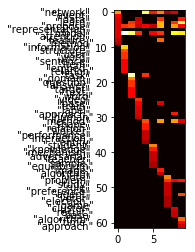

In [21]:
show_heapmap(DC,zz)

### Running LDA using TF-IDF

In [27]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, 
                                       num_topics=num_topics, 
                                       id2word=dictionary, 
                                       passes=20, 
                                       workers=2)

In [28]:
for idx, topic in lda_model_tfidf.print_topics(): #num_topics=3, num_words=3
    print('Topic: {}\nWords: {}\n'.format(idx, topic))

Topic: 0
Words: 0.001*"event" + 0.001*"algebraic" + 0.001*"discussion" + 0.001*"operator" + 0.001*"paraphrase" + 0.001*"anomaly" + 0.001*"clone" + 0.001*"critic" + 0.001*"turnover" + 0.001*"quasi"

Topic: 1
Words: 0.001*"wager" + 0.001*"anomaly" + 0.001*"logic" + 0.001*"poverty" + 0.001*"grammar" + 0.001*"dictionary" + 0.001*"chart" + 0.001*"commerce" + 0.001*"pamc" + 0.001*"dtis"

Topic: 2
Words: 0.003*"model" + 0.003*"learn" + 0.003*"network" + 0.003*"feature" + 0.003*"data" + 0.003*"method" + 0.003*"image" + 0.003*"algorithm" + 0.003*"label" + 0.003*"task"

Topic: 3
Words: 0.001*"neuron" + 0.001*"headline" + 0.001*"solitaire" + 0.001*"operator" + 0.001*"puzzle" + 0.001*"monotone" + 0.001*"solvable" + 0.001*"toolkit" + 0.001*"quota" + 0.001*"nonverbal"

Topic: 4
Words: 0.003*"dialogue" + 0.002*"medical" + 0.002*"dropout" + 0.002*"causal" + 0.002*"mapf" + 0.001*"equivalence" + 0.001*"paraphrase" + 0.001*"distortion" + 0.001*"satisfiability" + 0.001*"semidefinite"

Topic: 5
Words: 0.00

In [29]:
topicWordProbMat_tfidf = lda_model_tfidf.print_topics(num_topics=num_topics,num_words=num_words)
(df_words,DC,zz) = get_chart_data(num_topics,num_words,topicWordProbMat_tfidf)

show_words_table(df_words)
show_dictionary(DC)
show_probs_table(zz)

               1              2             3             4                  5            6              7
0       "event"        "wager"       "model"      "neuron"         "dialogue"   "fairness"         "hash" 
1   "algebraic"      "anomaly"       "learn"    "headline"          "medical"    "session"        "logic" 
2  "discussion"        "logic"     "network"   "solitaire"          "dropout"      "patch"     "ontology" 
3    "operator"      "poverty"     "feature"    "operator"           "causal"       "rpca"     "identity" 
4  "paraphrase"      "grammar"        "data"      "puzzle"             "mapf"       "sans"     "minority" 
5     "anomaly"   "dictionary"      "method"    "monotone"      "equivalence"      "story"    "discourse" 
6       "clone"        "chart"       "image"    "solvable"       "paraphrase"    "modular"   "pedestrian" 
7      "critic"     "commerce"   "algorithm"     "toolkit"       "distortion"   "metrical"     "skeleton" 
8    "turnover"         "pamc"       

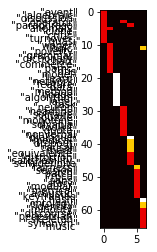

In [30]:
show_heapmap(DC,zz)